In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
import itertools
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_absolute_error, r2_score, confusion_matrix,ConfusionMatrixDisplay
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from itertools import combinations
import statistics

In [73]:
dataframe = pd.read_csv('./Asian_site_ard2.csv')
dataframe = dataframe[dataframe["Coincidence"] < 1].reset_index()
dataframe = dataframe.drop(columns=["index"])

In [74]:
dataframe

,PondID,pH,Salinity,Carbonate,BiCarbonate,Alkalinity,Hardness,Calcium,Magnesium,Ammonia,...,B1,B2,B3,B4,B5,B6,B7,B8A,B8,B9
0,TUPILIPALEM_A2,8.4,35,30,120,150,6300,388,1296,0.00,...,1500,1254,1163,926,1025,1062,1171,1188,920,185
1,TUPILIPALEM_A3,8.7,38,40,120,160,6800,472,1471,0.00,...,1477,1302,1167,887,899,918,1042,993,988,174
2,TUPILIPALEM_A4,8.7,39,40,110,150,6960,482,1488,0.00,...,1478,1186,1072,773,779,727,826,898,703,170
3,TUPILIPALEM_A5,8.7,40,40,120,160,7100,488,1491,0.00,...,1515,1208,989,798,881,879,992,1018,756,178
4,TUPILIPALEM_B2,8.6,36,50,110,160,6200,378,1302,0.00,...,1607,1237,1162,1111,1116,1217,1268,1254,828,227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,TUPILIPALEM_B4,8.1,40,0,150,150,7600,476,1572,0.06,...,1396,994,828,645,851,932,882,836,639,136
62,TUPILIPALEM_B5,8.3,40,30,140,170,7800,520,1579,0.05,...,1377,987,788,611,951,1093,1191,1163,604,128
63,TUPILIPALEM_B6,8.3,39,30,120,150,7700,502,1566,0.05,...,1409,988,823,635,1114,1171,1313,1294,637,137
64,TUPILIPALEM_B7,8.6,40,40,90,130,7800,594,1612,0.04,...,1344,974,814,651,942,1153,1103,1162,710,93


In [84]:
print("pH Minimum Value:", dataframe["pH"].min())
print("Salinity Minimum Value:", dataframe["Salinity"].min())

pH Minimum Value: 7.5
Salinity Minimum Value: 15


In [85]:
bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']
parameters = ["pH", "Salinity", "Ammonia"]

In [86]:
dataframe[["pH", "Salinity", "Ammonia"]].std()/np.array([8.5, 45, 0.5])

pH          0.044325
Salinity    0.187551
Ammonia     0.062056
dtype: float64

In [87]:
def calculateWQI(parameters):
    # order of parameters ph salinity ammonia
    permissibleValuesParameters = np.array([8.5, 45, 0.5])
    summ = 0
    sumWn = 0
    weights = np.array(parameters.std()/permissibleValuesParameters)
    weightsnormalized = weights/sum(weights)
    for column, sn, Wn in zip(parameters.columns, permissibleValuesParameters, weightsnormalized):
        vn = parameters[column]
        if column=="pH":
            vid = 7.5
        elif column=="Salinity":
            vid = 15
        else:
            vid = 0.0
        qn = 100*(vn - vid)/(sn-vid)
        summ = summ + (qn*Wn)
        sumWn = sumWn + Wn
    WQI = summ/sumWn
    return WQI


(array([ 4.,  9.,  3.,  4.,  7.,  1.,  3., 10., 13., 12.]),
 array([ 3.86049261, 10.80644526, 17.75239791, 24.69835056, 31.64430322,
        38.59025587, 45.53620852, 52.48216117, 59.42811383, 66.37406648,
        73.32001913]),
 <BarContainer object of 10 artists>)

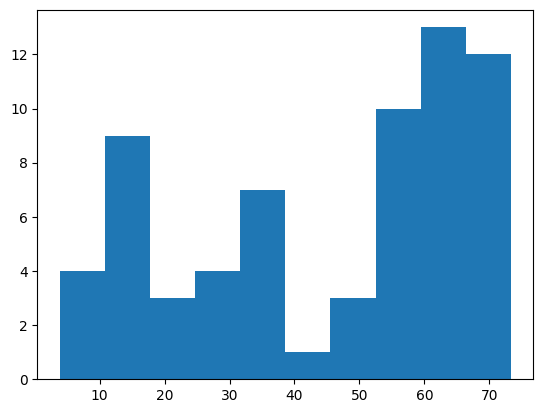

In [88]:
wqi = calculateWQI(dataframe[parameters])
## plotting distribution of wqi
plt.hist(wqi)

In [89]:
## printing stats for ground truth wqi
print("Mean WQI", statistics.mean(wqi))
print("Standard Deviation WQI", statistics.stdev(wqi))

Mean WQI 45.392442955198746
Standard Deviation WQI 22.111449426719723


In [90]:
### adding wqi as a dataframe 
dataframe["WQI"] = wqi

In [93]:
### model to predict WQI using bands as input
def predictWQI(dataframe):
    validationdataframe = dataframe[dataframe["Date of Image"]=="2023-07-09"]
    traindataframe = dataframe[dataframe["Date of Image"]!="2023-07-09"]
    # traindataframe, validationdataframe = train_test_split(dataframe, test_size=0.227)
    xTrain = traindataframe[bands]
    yTrain = traindataframe["WQI"]
    xTest = validationdataframe[bands]
    yTest = validationdataframe["WQI"]
    model = SVR(kernel='rbf', C=1.0, epsilon=1e-3)
    model.fit(xTrain, yTrain)
    prediction = model.predict(xTest)
    prediction = prediction
    print("MAE", mean_absolute_error(yTest, prediction))
    print("MSE", mean_squared_error(yTest, prediction))
    print("RMSE", mean_squared_error(yTest, prediction, squared=False))
    print("MAPE", mean_absolute_percentage_error(yTest, prediction))
    print("R2 Score", r2_score(yTest, prediction))
    plt.figure(figsize=(25,10))
    plt.scatter(np.arange(1, len(yTest)+1), yTest, color="red")
    plt.plot(np.arange(1, len(yTest)+1), prediction, color="blue")
    return prediction

MAE 9.361205887793744
MSE 119.67759998178552
RMSE 10.939725772695837
MAPE 0.2639866867552857
R2 Score 0.6627360072695645


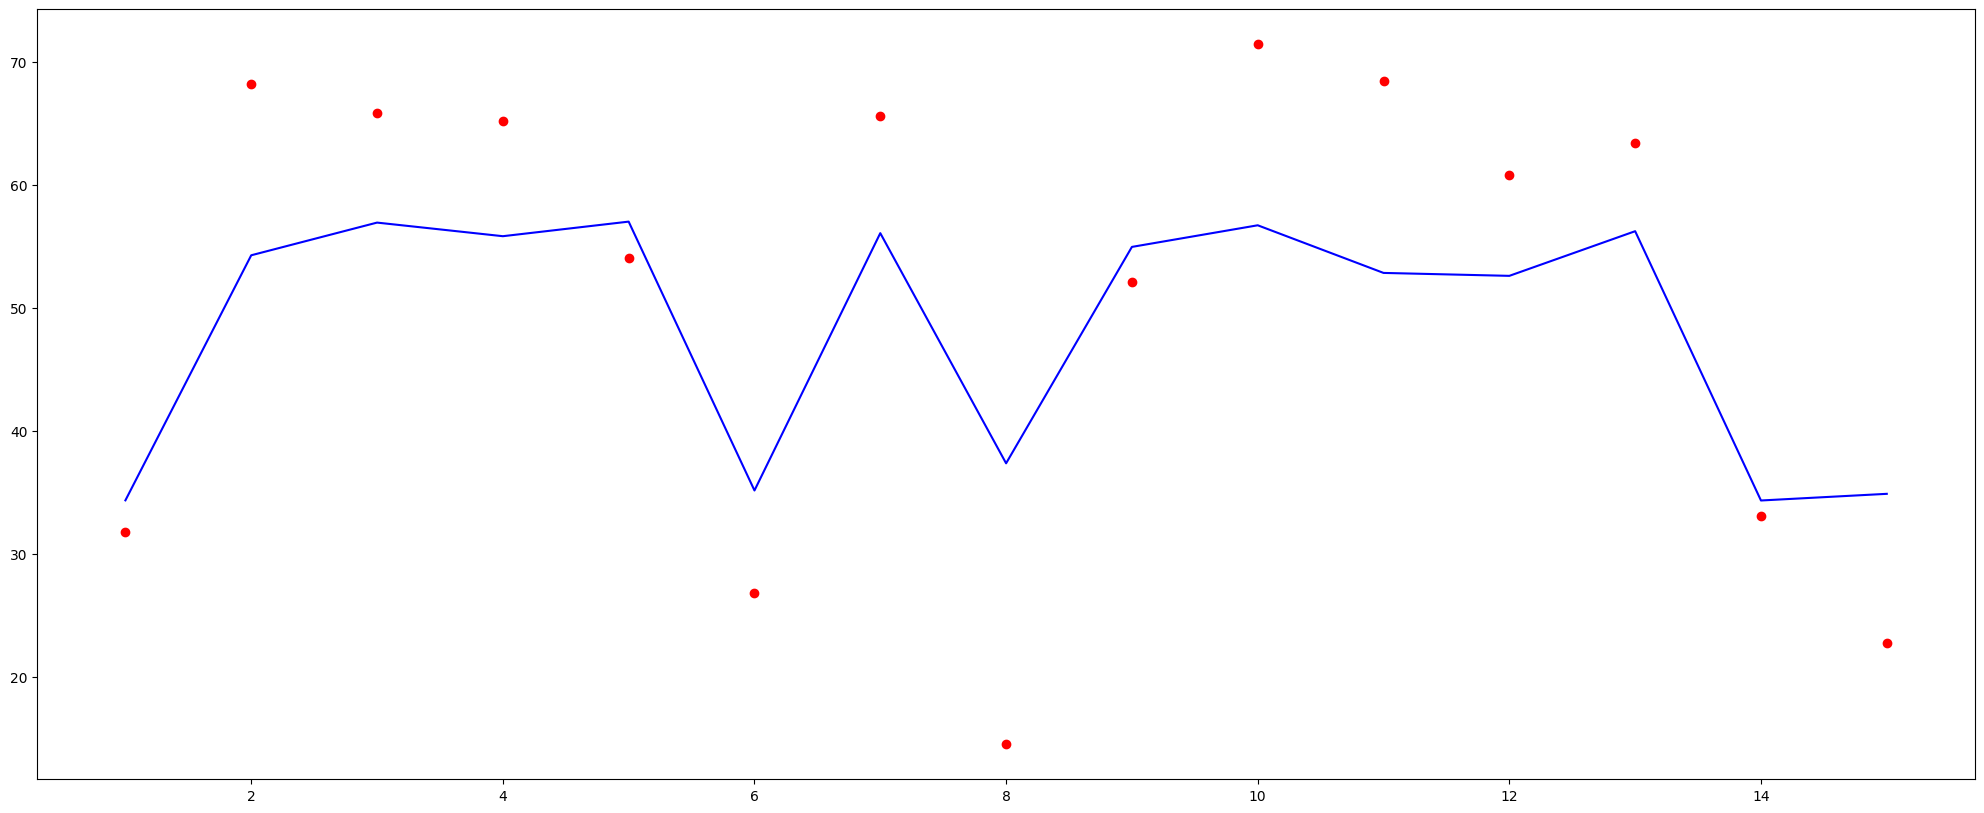

In [94]:
predictedWQI = predictWQI(dataframe)

In [63]:
## printing stats for ground truth wqi
print("Mean WQI", statistics.mean(predictedWQI))
print("Standard Deviation WQI", statistics.stdev(predictedWQI))

Mean WQI 50.97146702108294
Standard Deviation WQI 7.600041745512194


In [ ]:


#to train model to predict the WQI using band  indcies using ML
def WQIandBands(df1,WQI):
  print('-----For WQI prediction with Bands with SVR algo -----')
  X_test = df1.loc[df1['Date of Image'] == '2023-07-09'][['B11',	'B12'	,'B1',	'B2',	'B3',	'B4',	'B5',	'B6',	'B7',	'B8A',	'B8',	'B9']]
  y_test = df1.loc[df1['Date of Image'] == '2023-07-09'][['pH']]
  X_train = df1.loc[df1['Date of Image'] != '2023-07-09'][['B11',	'B12'	,'B1',	'B2',	'B3',	'B4',	'B5',	'B6',	'B7',	'B8A',	'B8',	'B9']]
  y_train = df1.loc[df1['Date of Image'] != '2023-07-09'][['pH']]
  # X_train, X_test, y_train, y_test = train_test_split(Bandsndices, WQI, test_size=0.33, random_state=42)
  model = SVR(kernel='rbf', C=1.0, epsilon=0.2)
  model.fit(X_train, y_train)
  prediction = model.predict(X_test)
  print("MAE", mean_absolute_error(y_test, prediction))
  print("MSE", mean_squared_error(y_test, prediction))
  print("RMSE", mean_squared_error(y_test, prediction, squared=False))
  print("MAPE", mean_absolute_percentage_error(y_test, prediction))
  print("R2 Score", r2_score(y_test, prediction))
  return prediction


def CM(actual, predicted):
  fig = plt.figure()
  plt.scatter(actual, predicted)
  plt.show()

def LRegression(WQI,GT):
  X_train, X_test, y_train, y_test = train_test_split(WQI, GT, test_size=0.33, random_state=42)
  model = LinearRegression().fit(X_train, y_train)
  # model1 = SVR(kernel='rbf', C=1.0, epsilon=0.2).fit(X_train, y_train)
  # model = RandomForestRegressor(max_depth=2, random_state=0).fit(X_train, y_train)
  prediction = model.predict(X_test)
  for x,y in zip(y_test.values,prediction):
    print(x,'-',y)

  CM(WQI,GT)
  print("MAE", mean_absolute_error(y_test, prediction))
  print("MSE", mean_squared_error(y_test, prediction))
  print("RMSE", mean_squared_error(y_test, prediction, squared=False))
  print("MAPE", mean_absolute_percentage_error(y_test, prediction))
  print("R2 Score", r2_score(y_test, prediction))
  # return model.coef_,model.intercept_
#to predict the parameters from WQI



def WQIandParameters(WQI,GT):
  print('-----For WQI with pH Regression relation-----')
  LRegression(WQI,GT['pH'])
  print('-----For WQI with Salinity  Regression relation-----')
  LRegression(WQI,GT['Salinity'])
  print('-----For WQI with Ammonia SVR relation-----')
  LRegression(WQI,GT['Ammonia'])
  return None



## WQI with only bands

In [ ]:
WQI = WQIcalculation(df1 ,GT1)
# len(WQI)
WQIandBands(df1,WQI)
WQIandParameters(np.array(WQI).reshape(-1, 1),GT)

In [ ]:
newdf = bandmath(normalized_Banddata,WQI)

In [ ]:
(newdf.columns)

## WQI with  top  10 combination indices

In [ ]:
corrwithWQI = newdf.corrwith(newdf['WQI_cal'])
type(corrwithWQI)
corrdict  = corrwithWQI.to_dict()
sortedkeys = sorted(corrdict, key=corrdict.get, reverse=True)
for r in sortedkeys[:11]:
    print(r, corrdict[r])

In [ ]:
newtraindf = newdf[sortedkeys].drop('WQI_cal',axis = 1)
scaler = StandardScaler()
scaler.fit(newtraindf)
newscaledtraindf = scaler.transform(newtraindf)
WQIandBands(newscaledtraindf,WQI)

In [ ]:
# plt.scatter(df['norm_NarrowNIR_SWIR1'],df['WQI_cal'])
# plt.scatter(df['norm_NarrowNIR_SWIR2'],df['WQI_cal'])
# plt.scatter(df['norm_WaterVapour_SWIR2'],df['WQI_cal'])

## WQI with  PCA 3 bands

In [ ]:
pca = PCA(n_components=3)
scaler = StandardScaler()
scaler.fit(Banddata)
scaled_banddata = scaler.transform(Banddata)
pca = PCA(n_components=2)
pca.fit(scaled_banddata)
pca_banddata =  pca.transform(scaled_banddata)

In [ ]:
WQIandBands(pca_banddata,WQI)